### Setup

In [1]:
# handling data
import pandas as pd
import numpy as np
import datetime as dt
import re

# deep learning
import tensorflow as tf
from tensorflow import keras
import keras.backend as K

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py

# style setup
import matplotlib as mpl
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 16)
mpl.rc('ytick', labelsize = 12)
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


### Loading data

In [2]:
df = pd.read_csv(r'C:\Users\Aless\Downloads\Churn_Modelling.csv', index_col = 'RowNumber')
df.columns = df.columns.map(lambda x: re.sub(r"(\w)([A-Z])", r"\1_\2", x))
df.shape

(10000, 13)

In [3]:
df.columns

Index(['Customer_Id', 'Surname', 'Credit_Score', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'Num_Of_Products', 'Has_Cr_Card',
       'Is_Active_Member', 'Estimated_Salary', 'Exited'],
      dtype='object')

In [4]:
df.dtypes

Customer_Id           int64
Surname              object
Credit_Score          int64
Geography            object
Gender               object
Age                   int64
Tenure                int64
Balance             float64
Num_Of_Products       int64
Has_Cr_Card           int64
Is_Active_Member      int64
Estimated_Salary    float64
Exited                int64
dtype: object

### Data validation

In [5]:
df.head()

,Customer_Id,Surname,Credit_Score,Geography,Gender,Age,Tenure,Balance,Num_Of_Products,Has_Cr_Card,Is_Active_Member,Estimated_Salary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df.isna().sum()

Customer_Id         0
Surname             0
Credit_Score        0
Geography           0
Gender              0
Age                 0
Tenure              0
Balance             0
Num_Of_Products     0
Has_Cr_Card         0
Is_Active_Member    0
Estimated_Salary    0
Exited              0
dtype: int64

In [7]:
sum(df.Customer_Id.duplicated())

0

### Exploratory data analysis

Text(0.5, 1.0, 'Age distribution')

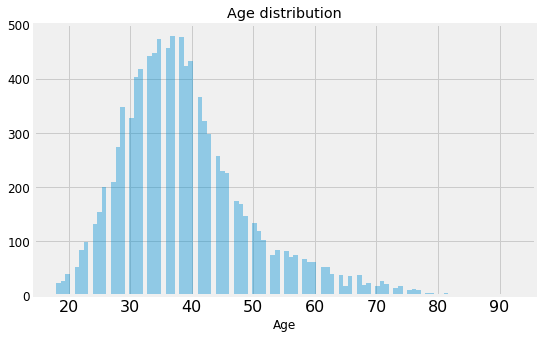

In [8]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.distplot(df.Age, kde=False, bins = 100)
plt.title('Age distribution')

Pearson correlation:  0.006268381616008724


Text(0, 0.5, 'Credit score')

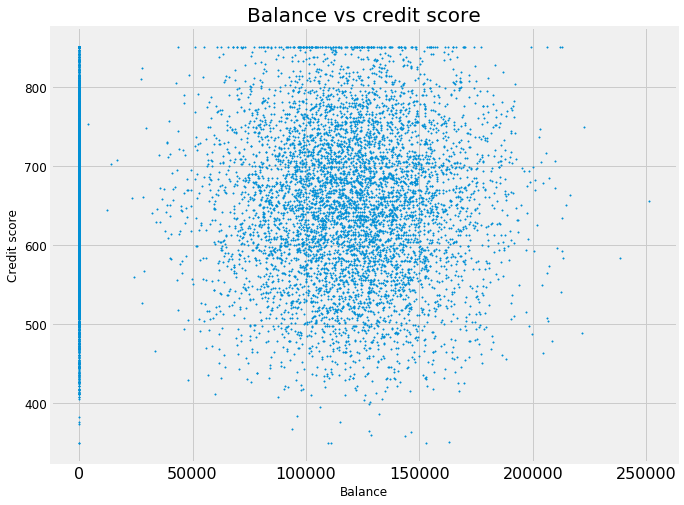

In [9]:
fig, ax = plt.subplots(figsize = (10, 8))
plt.scatter(df.Balance, df.Credit_Score, s = 2)
print('Pearson correlation: ', np.corrcoef(df.Balance, df.Credit_Score)[0, 1])
plt.title('Balance vs credit score', fontsize = 20)
plt.xlabel('Balance'); plt.ylabel('Credit score')

In [10]:
df.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

It seems that we have only european customers. Let us plot these number on a geographical map

### Preprocessing

In order to achieve better perfomance i am going to compute false and true weights over the data. This will be used by the classifiers to balance the two classes

In [11]:
df_preprocess = df.drop(['Customer_Id', 'Surname'], axis = 1)
df_preprocess.Gender = df_preprocess.Gender.apply(lambda x: 1 if x == 'Male' else 0)
df_preprocess = pd.concat([df_preprocess, pd.get_dummies(df.Geography)], axis = 1).drop('Geography', axis = 1)
num_col = [0, 2, 4, 8]
X = df_preprocess.drop('Exited', axis = 1).values
y = df_preprocess['Exited'].values
false_weight = 1 / np.bincount(y)[0]
true_weight = 1 / np.bincount(y)[1]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

poly = PolynomialFeatures(degree = 2)
poly.fit(X_train)
X_train = poly.transform(X_train)
scaler = MinMaxScaler()
scaler.fit(X_train[:, num_col])
X_train[:, num_col] = scaler.transform(X_train[:, num_col])
X_test = poly.transform(X_test)
X_test[:, num_col] = scaler.transform(X_test[:, num_col])

### Comparing many classifiers at the same time

F1 is a good metric to evaluate classifier perfomance in imbalanced datasets. If we want to use more metrics in the future it will be a good idea to write a function besides 'build_table' in order to collect the desidered metrics 

In [12]:
def build_table(clfs, accuracies, recalls, f1_scores):
    table = pd.DataFrame({'Classifier' : clfs,
                          'Accuracy' : accuracies,
                          'Recall' : recalls,
                          'F1_score' : f1_scores})
    return table

clfs = []
accuracies = []
recalls = []
f1_scores = []

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver = 'lbfgs', max_iter = 250,
                             class_weight = {0 : false_weight, 1 : true_weight})
clfs.append('Logistic Regression')

from sklearn.model_selection import cross_val_score

accuracies.append(cross_val_score(log_reg, X_train, y_train, cv = 10, scoring = 'accuracy').mean())
recalls.append(cross_val_score(log_reg, X_train, y_train, cv = 10, scoring = 'recall').mean())
f1_scores.append(cross_val_score(log_reg, X_train, y_train, cv = 10, scoring = 'f1').mean())

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(class_weight = {0 : false_weight, 1 : true_weight})
clfs.append('Decision tree')
accuracies.append(cross_val_score(tree, X_train, y_train, cv = 10, scoring = 'accuracy').mean())
recalls.append(cross_val_score(tree, X_train, y_train, cv = 10, scoring = 'recall').mean())
f1_scores.append(cross_val_score(tree, X_train, y_train, cv = 10, scoring = 'f1').mean())


from sklearn.svm import SVC

svc = SVC(gamma = 'auto', class_weight = {0 : false_weight, 1 : true_weight})
clfs.append('Supported vector machine')
accuracies.append(cross_val_score(svc, X_train, y_train, cv = 10, scoring = 'accuracy').mean())
recalls.append(cross_val_score(svc, X_train, y_train, cv = 10, scoring = 'recall').mean())
f1_scores.append(cross_val_score(svc, X_train, y_train, cv = 10, scoring = 'f1').mean())

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 200, class_weight = {0 : false_weight, 1 : true_weight})
clfs.append('Random forest')
accuracies.append(cross_val_score(rfc, X_train, y_train, cv = 10, scoring = 'accuracy').mean())
recalls.append(cross_val_score(rfc, X_train, y_train, cv = 10, scoring = 'recall').mean())
f1_scores.append(cross_val_score(rfc, X_train, y_train, cv = 10, scoring = 'f1').mean())

import xgboost as xgb

xgb_clf = xgb.XGBClassifier(n_estimators = 200, class_weight = {0 : false_weight, 1 : true_weight})
clfs.append('Xgboost')
accuracies.append(cross_val_score(xgb_clf, X_train, y_train, cv = 10, scoring = 'accuracy').mean())
recalls.append(cross_val_score(xgb_clf, X_train, y_train, cv = 10, scoring = 'recall').mean())
f1_scores.append(cross_val_score(xgb_clf, X_train, y_train, cv = 10, scoring = 'f1').mean())
table = build_table(clfs, accuracies, recalls, f1_scores)
table

,Classifier,Accuracy,Recall,F1_score
0,Logistic Regression,0.648750,0.673620,0.438806
1,Decision tree,0.795500,0.495706,0.496112
2,Supported vector machine,0.203750,1.000000,0.338525
3,Random forest,0.860125,0.454601,0.565744
4,Xgboost,0.853375,0.494479,0.577788


### Tuning 

Xgb is the classifier with the highest F1 score. Let us tune it

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, make_scorer

params = {'n_estimators' : [100, 150, 200, 250, 300],
          'eta' : np.arange(0.05, 0.8, 0.1),
          'max_depth' : [3, 4, 6, None],
          'min_samples_split' : [2, 3, 6, None],
          'gamma' : list(range(1, 11))}
scorer = make_scorer(f1_score)
grid_search =  RandomizedSearchCV(estimator = xgb_clf, param_distributions = params, scoring = 'f1', n_iter = 20, cv = 3)
grid_search.fit(X_train, y_train)
xgb_tuned = xgb.XGBClassifier(**grid_search.best_params_)
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.7500000000000002,
              gamma=6, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.75,
              max_delta_step=0, max_depth=6, min_child_weight=1,
              min_samples_split=6, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

### Evaluation on production

Accuracy of the model:  0.8575
Recall of the model:  0.5061
F1_score:  0.5911


(array([0.5, 1.5]), <a list of 2 Text yticklabel objects>)

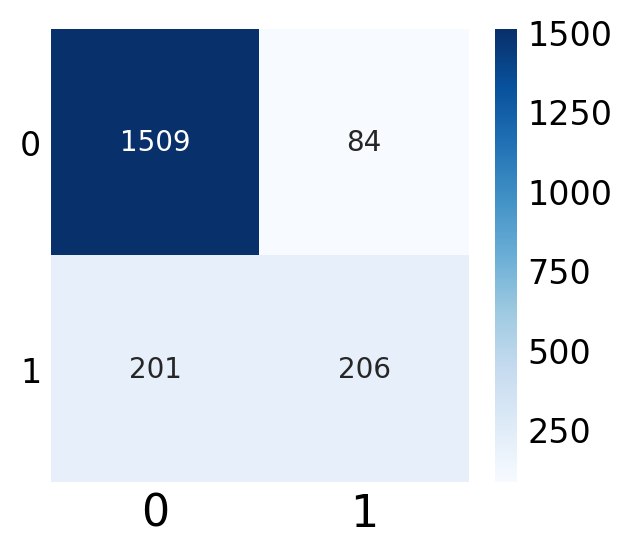

In [14]:
y_pred = xgb_tuned.predict(X_test)
print('Accuracy of the model: ', np.round(accuracy_score(y_test, y_pred), 4))
print('Recall of the model: ', np.round(recall_score(y_test, y_pred), 4))
print('F1_score: ', np.round(f1_score(y_test, y_pred), 4))
confusionMatrix = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize = (3, 3), dpi = 200)
sns.heatmap(confusionMatrix, annot = True, cmap = 'Blues', fmt = 'd')
plt.yticks(rotation = 0)

### Visualizing the roc-auc-curve

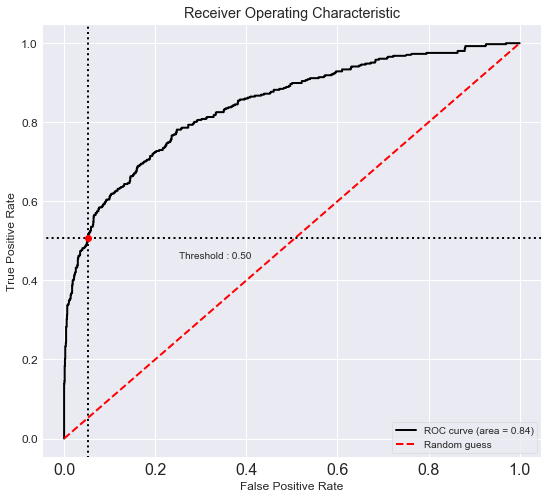

Roc auc score of : 0.843


In [15]:
from plot_metric.functions import BinaryClassification
from sklearn.metrics import roc_auc_score

y_pred_proba = xgb_tuned.predict_proba(X_test)[:, 1]
b_clf = BinaryClassification(y_test, y_pred_proba, labels = ["Exited"])
plt.figure(figsize = (8,8))
b_clf.plot_roc_curve()
plt.show()
print('Roc auc score of :', np.round(roc_auc_score(y_test, y_pred_proba), 3))

The clf seems to have a good roc_auc_score. However we can still improve it working more on feature creation and preprocessing